# Binary Classification on Heart Disease Data

## Loading Essentials and Helper Functions 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib
import os
import time

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

from matplotlib import pyplot as plt

%matplotlib inline

import random 
random.seed(42) 

from helper import save_fig, draw_confusion_matrix, heatmap, make_meshgrid, plot_contours, draw_contour

# Project: Using classification methods to classify heart disease


## Background: The Dataset 


The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> Male / Female</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> cholesterol in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    


In [2]:
data = pd.read_csv('datasets/heartdisease.csv')

In [3]:
print(data.head(5))
print(data.describe())
print(data.info())

   age     sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0   63    Male   3       145   233    1        0      150      0      2.3   
1   37    Male   2       130   250    0        1      187      0      3.5   
2   41  Female   1       130   204    0        0      172      0      1.4   
3   56    Male   1       120   236    0        1      178      0      0.8   
4   57  Female   0       120   354    0        1      163      1      0.6   

   slope  ca  thal   sick  
0      0   0     1  False  
1      0   0     2  False  
2      2   0     2  False  
3      2   0     2  False  
4      2   0     2  False  
              age          cp    trestbps        chol         fbs     restecg  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.966997  131.623762  246.264026    0.148515    0.528053   
std      9.082101    1.032052   17.538143   51.830751    0.356198    0.525860   
min     29.000000    0.000000   94.000000  12

In [4]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
sick        0
dtype: int64

**Transform binary columns to ones and zeros**

In [5]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 

data['sex'] = le.fit_transform(data['sex'])
data['sick'] = le.fit_transform(data['sick'])
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


## Data Visualizations

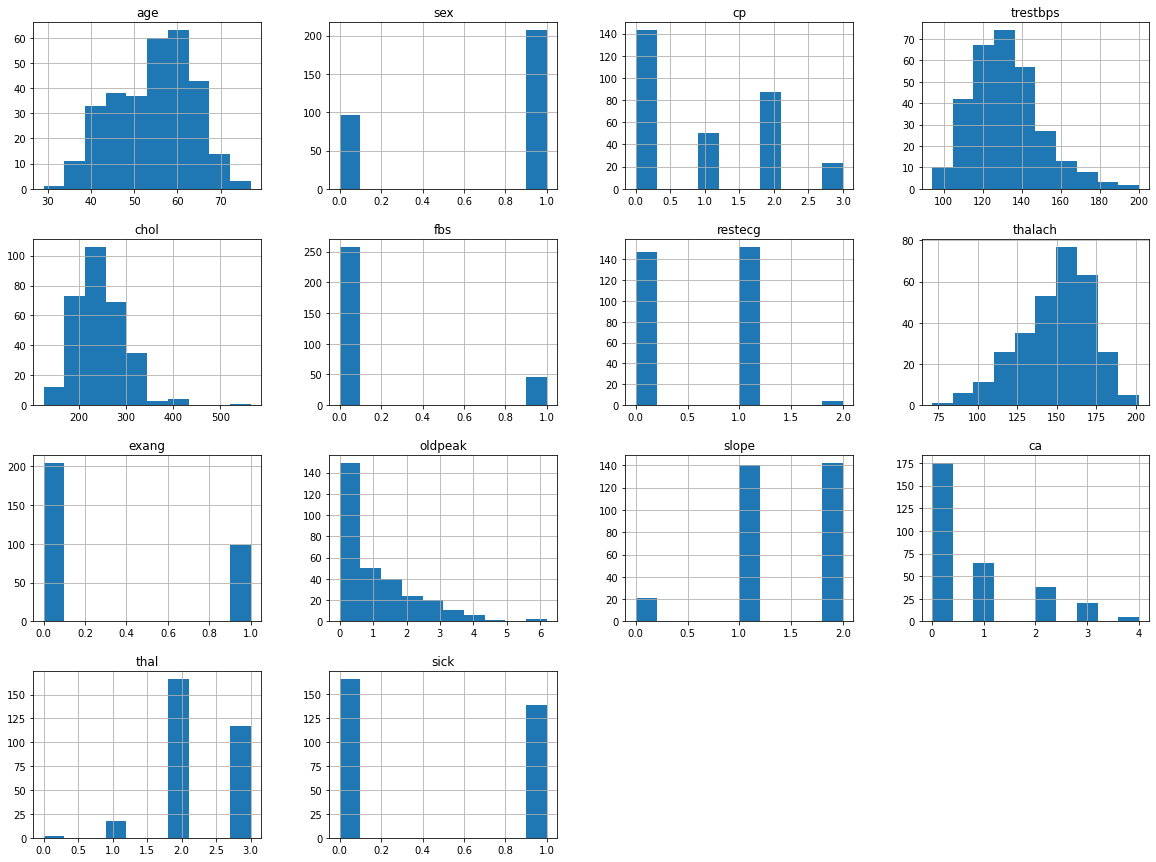

In [6]:
data.hist(figsize = (20,15))
plt.show()

0    165
1    138
Name: sick, dtype: int64

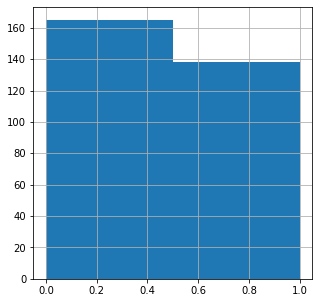

In [7]:
data['sick'].hist(bins=2, figsize=(5,5))
data['sick'].value_counts()

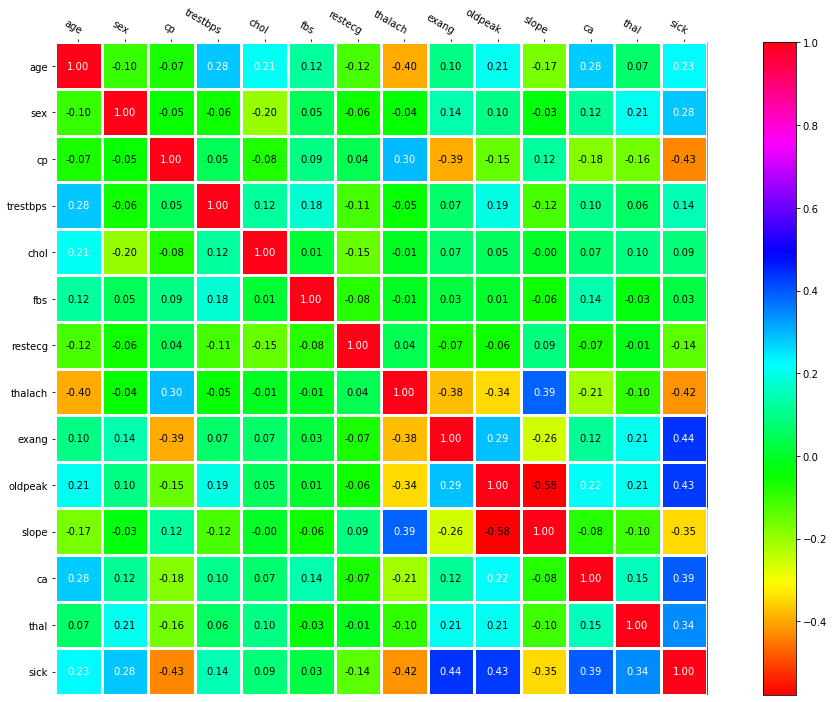

In [8]:
correlations = data.corr()
columns = list(data)
heatmap(correlations.values, columns, columns, figsize=(20, 12), cmap="hsv")

In [9]:
correlations["sick"].sort_values(ascending=False)

sick        1.000000
exang       0.436757
oldpeak     0.430696
ca          0.391724
thal        0.344029
sex         0.280937
age         0.225439
trestbps    0.144931
chol        0.085239
fbs         0.028046
restecg    -0.137230
slope      -0.345877
thalach    -0.421741
cp         -0.433798
Name: sick, dtype: float64

### Train/test split

In [10]:
y = data["sick"]
x = data.drop(["sick"],axis = 1)

In [11]:
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.4, stratify= y, random_state = 0)

In [12]:
print("Shape of training features:", train_raw.shape)
print("Shape of testing features:", test_raw.shape)
print("Shape of training targets:", target.shape)
print("Shape of testing targets:", target_test.shape)

Shape of training features: (181, 13)
Shape of testing features: (122, 13)
Shape of training targets: (181,)
Shape of testing targets: (122,)


In [13]:
print("Training target counts:")
target.value_counts()

Training target counts:


0    99
1    82
Name: sick, dtype: int64

In [14]:
print("Testing target counts:")
target_test.value_counts()

Testing target counts:


0    66
1    56
Name: sick, dtype: int64

### Classification using KNN

**First on raw data. Notice the low accuracy before we process the data.**

Accuracy:    0.655738
Confusion Matrix: 
 [[49 17]
 [25 31]]


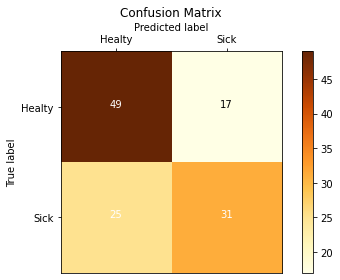

In [15]:
knn = KNeighborsClassifier()
knn.fit(train_raw, target)
predicted = knn.predict(test_raw)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Healty', 'Sick'])

### Data Preprocessing
We are standardizing numerical data and one hot encoding the categorical data.

In [16]:
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns), 
        ('cat', OneHotEncoder(), categorical_columns)
    ])

In [17]:
train = preprocessor.fit_transform(train_raw)
test = preprocessor.transform(test_raw)

In [18]:
knn = KNeighborsClassifier()
knn.fit(train, target)
predicted = knn.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

Accuracy:    0.754098


### Find Better Parameter Values

In [19]:
k_r = [1, 3, 5, 9, 15, 25, 49]
for k in k_r:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train, target)
    testing_result = knn.predict(test)
    predicted = knn.predict(test)
    print('Accuracy of ', k, ': ', metrics.accuracy_score(target_test,predicted))

Accuracy of  1 :  0.7704918032786885
Accuracy of  3 :  0.7540983606557377
Accuracy of  5 :  0.7540983606557377
Accuracy of  9 :  0.7786885245901639
Accuracy of  15 :  0.7950819672131147
Accuracy of  25 :  0.7786885245901639
Accuracy of  49 :  0.7704918032786885


## Logistic Regression Models

Accuracy:    0.819672
Confusion Matrix: 
 [[61  5]
 [17 39]]


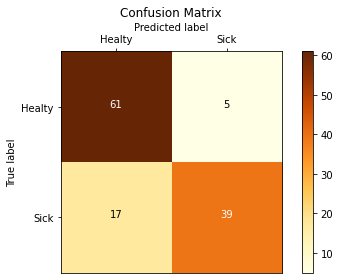

In [20]:
log_reg = LogisticRegression()

log_reg.fit(train, target)
testing_result = log_reg.predict(test)
predicted = log_reg.predict(test)

print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Healty', 'Sick'])

Accuracy:    0.819672
Confusion Matrix: 
 [[61  5]
 [17 39]]


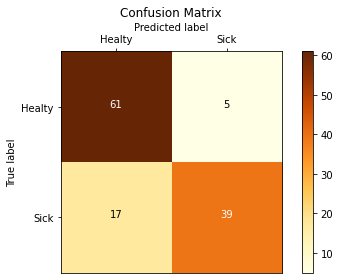

In [21]:
log_reg = LogisticRegression(penalty="l2", max_iter=1000, solver="saga", C=1)

log_reg.fit(train, target)
testing_result = log_reg.predict(test)
predicted = log_reg.predict(test)

print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Healty', 'Sick'])

Accuracy:    0.827869
[[61  5]
 [16 40]]


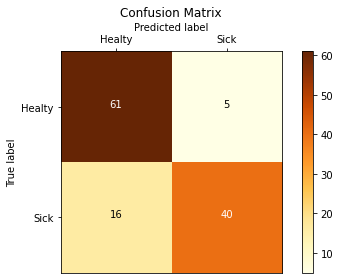

In [22]:
log_reg = LogisticRegression(penalty="l1", max_iter=1000, solver="saga", C=1)

log_reg.fit(train, target)
testing_result = log_reg.predict(test)
predicted = log_reg.predict(test)

print("%-12s %f" % ("Accuracy:", metrics.accuracy_score(target_test, predicted)))
print(confusion_matrix(target_test, predicted))
draw_confusion_matrix(target_test, predicted, ['Healty', 'Sick'])

## SVM Models

Accuracy:    0.803279
Confusion Matrix: 
 [[62  4]
 [20 36]]


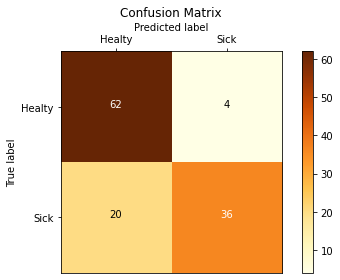

[54 52]


In [23]:
svm = SVC()
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Healty', 'Sick'])
print(svm.n_support_)

Accuracy:    0.844262
Confusion Matrix: 
 [[62  4]
 [15 41]]


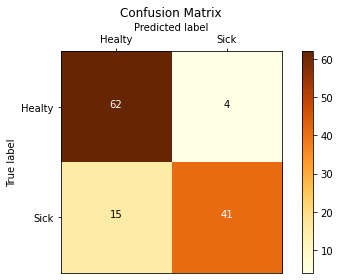

[34 31]


In [24]:
svm = SVC(kernel='linear')
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Healty', 'Sick'])
print(svm.n_support_)

## [10 pts] Part 5: Cross Validation and Model Selection

You've sampled a number of different classification techniques and have seen their performance on the dataset. 
Before we draw any conclusions on which model is best, we want to ensure that our results are not the result of the random sampling of our data we did with the Train-Test-Split. To ensure otherwise we will conduct a K-Fold Cross-Validation with GridSearch to determine which model perform best and assess its performance on the test set.

### [10 pts]  Model Selection

Run a `GridSearchCV` with 3-Fold Cross Validation. You will be running each classification model with different parameters. 

KNN:
- `n_neighbors = [1,3,5,7]`
- `metric = ["euclidean","manhattan"] #Different Distance functions`

Logistic Regression:
- `penalty = ["l1","l2"]`
- `solver = ["liblinear","saga"]`
- `C = [0.001,0.1,10]`

SVM:
- `kernel = ["linear","rbf"]`
- `C = [0.001,0.1,10]`


Make sure to train and test your model on the transformed data and not on the raw data.

*Note: You may have to increase the number of iterations for convergence for some of the models.*

After using `GridSearchCV`, put the results into a `pandas Dataframe` and print out the whole table.

In [25]:
knnParameters = {
    "n_neighbors": [1, 3, 5, 7],
    "metric": ["euclidean", "manhattan"]
}

logregParameters = {
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"],
    "C": [0.001, 0.1, 10]
}

svmParameters = {
    "kernel": ["linear", "rbf"],
    "C": [0.001, 0.1, 10]
}
knn = KNeighborsClassifier()
log_reg = LogisticRegression(max_iter=1000)
svm = SVC()
k = 3
kf = KFold(n_splits=k, random_state=None)

In [26]:
grid1 = GridSearchCV(knn, knnParameters, cv=kf, scoring="accuracy")
grid1.fit(train, target)
grid2 = GridSearchCV(log_reg, logregParameters, cv=kf, scoring="accuracy")
grid2.fit(train, target)
grid3 = GridSearchCV(svm, svmParameters, cv=kf, scoring="accuracy")
grid3.fit(train, target)
res1 = pd.DataFrame(grid1.cv_results_)
res2 = pd.DataFrame(grid2.cv_results_)
res3 = pd.DataFrame(grid3.cv_results_)
res1 = res1[["rank_test_score", "param_n_neighbors", "param_metric", "mean_test_score"]]
res2 = res2[["rank_test_score", "param_C", "param_penalty", "param_solver", "mean_test_score"]]
res3 = res3[["rank_test_score", "param_kernel", "param_C", "mean_test_score"]]
print(res1)
print(res2)
print(res3)

   rank_test_score param_n_neighbors param_metric  mean_test_score
0                7                 1    euclidean         0.768124
1                3                 3    euclidean         0.828871
2                1                 5    euclidean         0.829053
3                6                 7    euclidean         0.812477
4                8                 1    manhattan         0.762568
5                3                 3    manhattan         0.828871
6                2                 5    manhattan         0.828962
7                5                 7    manhattan         0.823497
    rank_test_score param_C param_penalty param_solver  mean_test_score
0                11   0.001            l1    liblinear         0.547450
1                12   0.001            l1         saga         0.469672
2                 7   0.001            l2    liblinear         0.784791
3                10   0.001            l2         saga         0.641894
4                 9     0.1          

In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grids
knnParameters = {'n_neighbors': [3, 5, 7], 'metric': ['euclidean', 'manhattan']}
logregParameters = {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs']}
svmParameters = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Initialize models
knn = KNeighborsClassifier()
log_reg = LogisticRegression()
svm = SVC()

# Perform GridSearchCV for each model
grid1 = GridSearchCV(knn, knnParameters, cv=kf, scoring="accuracy")
grid1.fit(train, target)

grid2 = GridSearchCV(log_reg, logregParameters, cv=kf, scoring="accuracy")
grid2.fit(train, target)

grid3 = GridSearchCV(svm, svmParameters, cv=kf, scoring="accuracy")
grid3.fit(train, target)

# Create DataFrames to hold the results
res1 = pd.DataFrame(grid1.cv_results_)
res2 = pd.DataFrame(grid2.cv_results_)
res3 = pd.DataFrame(grid3.cv_results_)

# Extract relevant information from the results
res1 = res1[["rank_test_score", "param_n_neighbors", "param_metric", "mean_test_score"]]
res2 = res2[["rank_test_score", "param_C", "param_penalty", "param_solver", "mean_test_score"]]
res3 = res3[["rank_test_score", "param_kernel", "param_C", "mean_test_score"]]

# Print the results
print("KNN Results:\n", res1)
print("Logistic Regression Results:\n", res2)
print("SVM Results:\n", res3)

# Find the best mean test scores
best_knn_score = res1["mean_test_score"].max()
best_logreg_score = res2["mean_test_score"].max()
best_svm_score = res3["mean_test_score"].max()

# Determine the best model overall
best_model = None
best_score = 0

if best_knn_score > best_score:
    best_score = best_knn_score
    best_model = 'KNN'

if best_logreg_score > best_score:
    best_score = best_logreg_score
    best_model = 'Logistic Regression'

if best_svm_score > best_score:
    best_score = best_svm_score
    best_model = 'SVM'

# Print the best parameters and best accuracy for each model
print("Best Parameters for KNN:", grid1.best_params_)
print("Best Accuracy for KNN:", best_knn_score)

print("Best Parameters for Logistic Regression:", grid2.best_params_)
print("Best Accuracy for Logistic Regression:", best_logreg_score)

print("Best Parameters for SVM:", grid3.best_params_)
print("Best Accuracy for SVM:", best_svm_score)

print(f"BEST MODEL: {best_model} with mean accuracy: {best_score}")

KNN Results:
    rank_test_score param_n_neighbors param_metric  mean_test_score
0                2                 3    euclidean         0.823123
1                5                 5    euclidean         0.789940
2                6                 7    euclidean         0.784535
3                4                 3    manhattan         0.806757
4                3                 5    manhattan         0.817718
5                1                 7    manhattan         0.828529
Logistic Regression Results:
    rank_test_score param_C param_penalty param_solver  mean_test_score
0                3     0.1            l2        lbfgs         0.817417
1                1       1            l2        lbfgs         0.828829
2                2      10            l2        lbfgs         0.817718
SVM Results:
    rank_test_score param_kernel param_C  mean_test_score
0                1       linear     0.1         0.839790
1                5          rbf     0.1         0.806456
2                2

Accuracy:    0.811475
Confusion Matrix: 
 [[60  6]
 [17 39]]


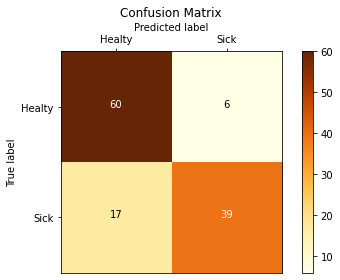

[42 40]


In [28]:
svm = SVC(C=0.1, kernel='linear')
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Healty', 'Sick'])
print(svm.n_support_)

### Analysis
SVM with C=0.1 and using a linear kernel performed the best with the training data. This shows that a linear decision boundary does a good job at seperating the data. 

How can we improve this model?

One idea I have is to try an ensemble method. I will do this below.

## Ensemble method

Accuracy:    0.795082
Confusion Matrix: 
 [[60  6]
 [19 37]]


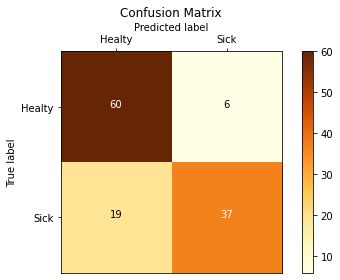

In [29]:
from sklearn.ensemble import VotingClassifier

best_knn = grid1.best_estimator_
best_log_reg = grid2.best_estimator_
best_svm = grid3.best_estimator_

# Ensemble model using majority voting
ensemble = VotingClassifier(estimators=[
    ('knn', best_knn),
    ('log_reg', best_log_reg),
    ('svm', best_svm)
], voting='hard')

# Train the ensemble model
ensemble.fit(train, target)

# Make predictions
predicted = ensemble.predict(test)

# Evaluate the ensemble model
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Healty', 'Sick'])


The ensemble method did not help us create a better model as it performed slightly worse than the SVM model that performed the best during the cross validation.